In [1]:
from msdm.domains import GridWorld
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.core.problemclasses.mdp import TabularPolicy
from algorithms import MaxLikelihoodIRL
import torch
from frozendict import frozendict
from dataset import TrajectoryDataset

# Corresponds to supervised_irl_example1 w/ epochs=10, batch_size=128, 100000 trajectories, lr=0.1, weight_decay=0.0001, momentum=0.9

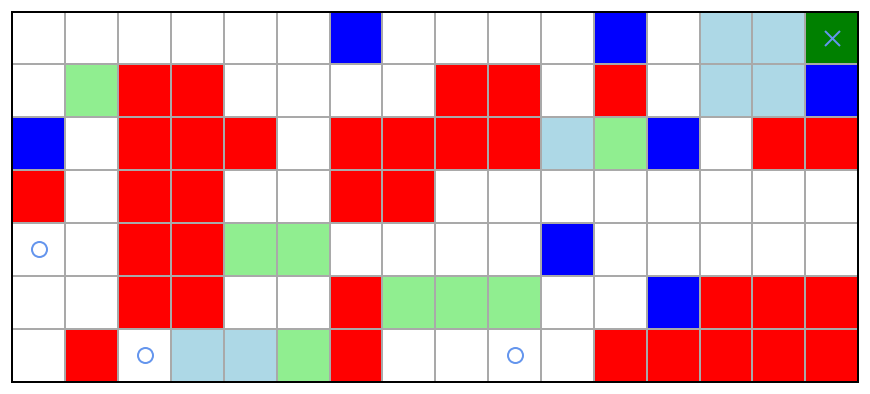

In [2]:
# Create a gridworld
mdp = GridWorld(
    tile_array=[
        "......c....c.bbg",
        ".axx....xx.x.bbc",
        "c.xxx.xxxxbac.xx",
        "x.xx..xx........",
        "s.xxaa....c.....",
        "..xx..xaaa..cxxx",
        ".xsbbax..s.xxxxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=0.99,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
mdp.plot(featurecolors=featurecolors)


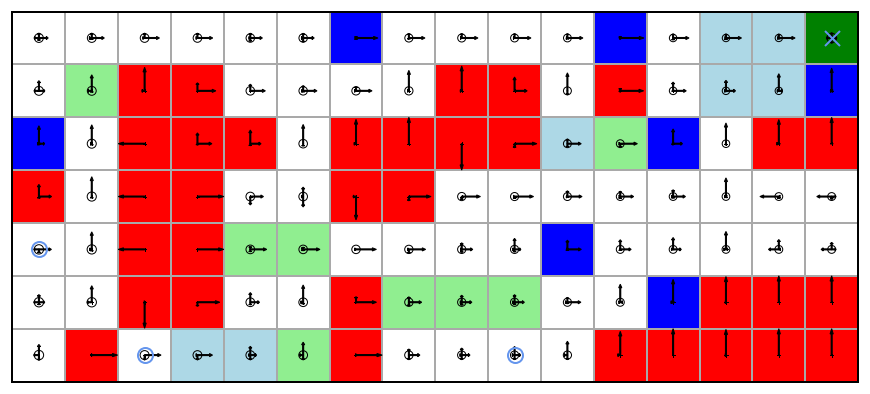

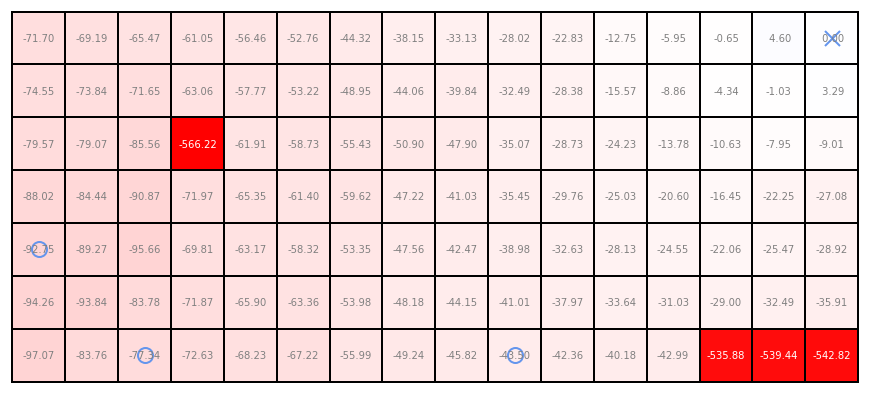

In [3]:
# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([3.9]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp.state_list, expert_erpi.state_values))
mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [4]:
# Generate gen_iters of trajectories
gen_iters = 100000
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

trajs_dataset = TrajectoryDataset(trajectories)

In [5]:
def featurizer(state, action, next_state):
  feature_name = mdp.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}

def fixed_reward(state, action, next_state):
  return mdp.step_cost

In [6]:
algorithm = MaxLikelihoodIRL(mdp, featurizer, fixed_reward, batch_size=128, epochs=10, lr=0.1, weight_decay=0.0001, momentum=0.9)
learned_weights, the_policy = algorithm.learn(trajs_dataset)

Using cuda
Inital reward weights: tensor([-0.9262, -0.6712,  1.3645, -0.9066], dtype=torch.float64)

loss: 0.063585  [    0/100000]
loss: 0.064610  [  256/100000]
loss: 0.064112  [  512/100000]
loss: 0.066024  [  768/100000]
loss: 0.059393  [ 1024/100000]
loss: 0.062158  [ 1280/100000]
loss: 0.062701  [ 1536/100000]
loss: 0.067523  [ 1792/100000]
loss: 0.058497  [ 2048/100000]
loss: 0.058879  [ 2304/100000]
loss: 0.061246  [ 2560/100000]
loss: 0.062535  [ 2816/100000]
loss: 0.062325  [ 3072/100000]
loss: 0.061492  [ 3328/100000]
loss: 0.064927  [ 3584/100000]
loss: 0.061499  [ 3840/100000]
loss: 0.060347  [ 4096/100000]
loss: 0.061060  [ 4352/100000]
loss: 0.063428  [ 4608/100000]
loss: 0.062780  [ 4864/100000]
loss: 0.058252  [ 5120/100000]
loss: 0.062700  [ 5376/100000]
loss: 0.061489  [ 5632/100000]
loss: 0.061476  [ 5888/100000]
loss: 0.062623  [ 6144/100000]
loss: 0.062930  [ 6400/100000]
loss: 0.059900  [ 6656/100000]
loss: 0.062327  [ 6912/100000]
loss: 0.064217  [ 7168/100000]


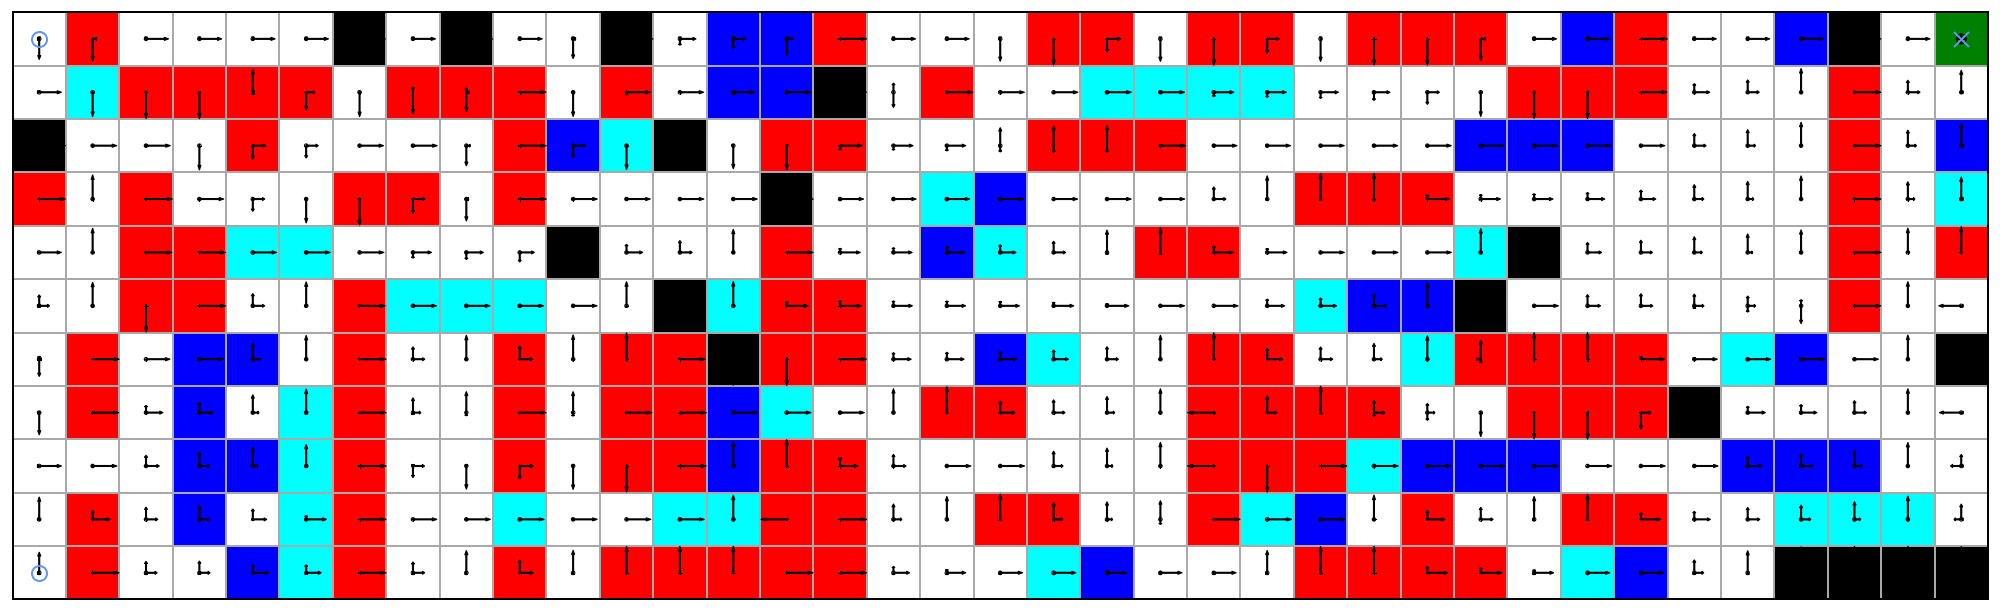

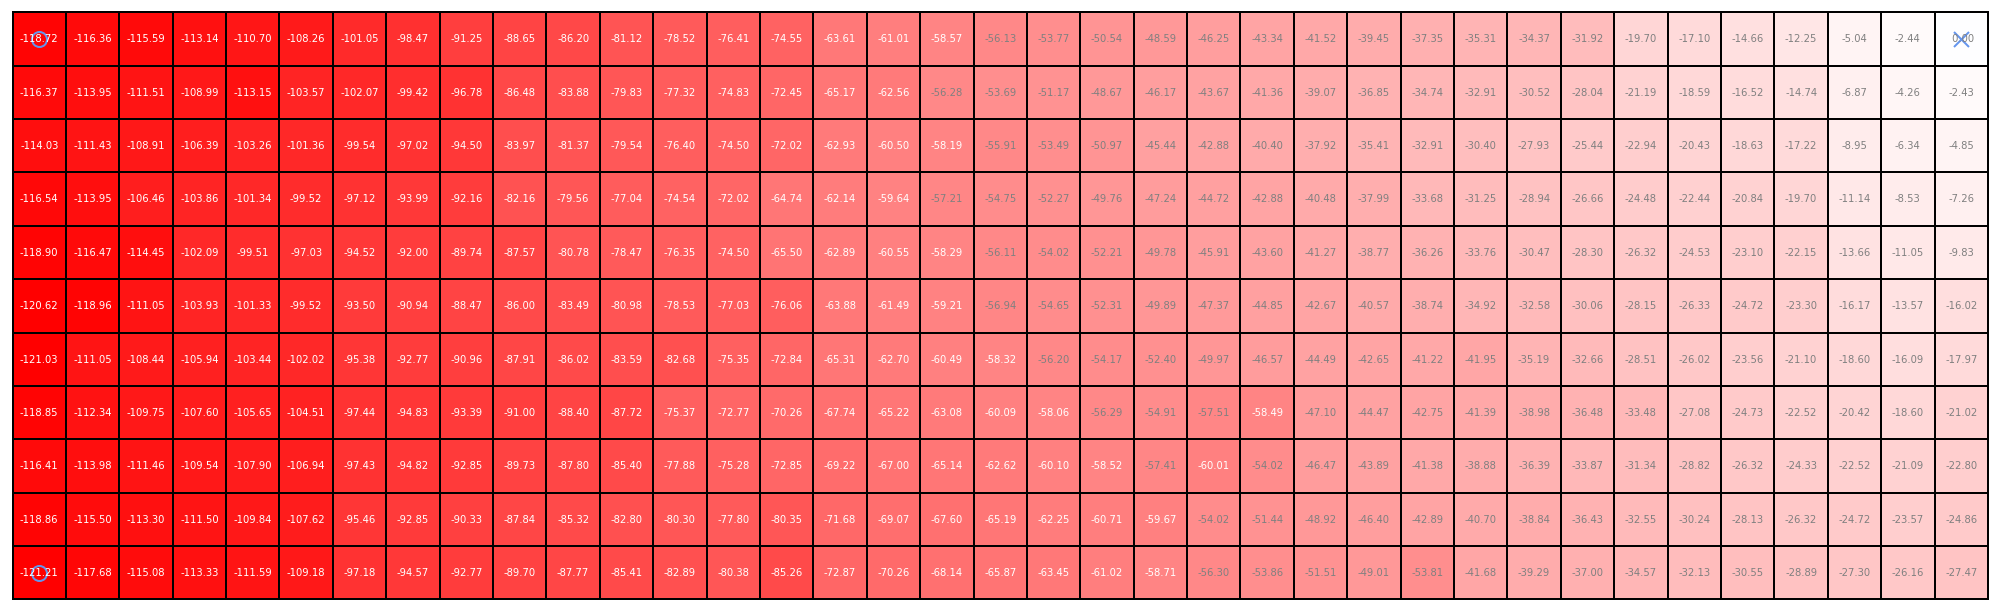

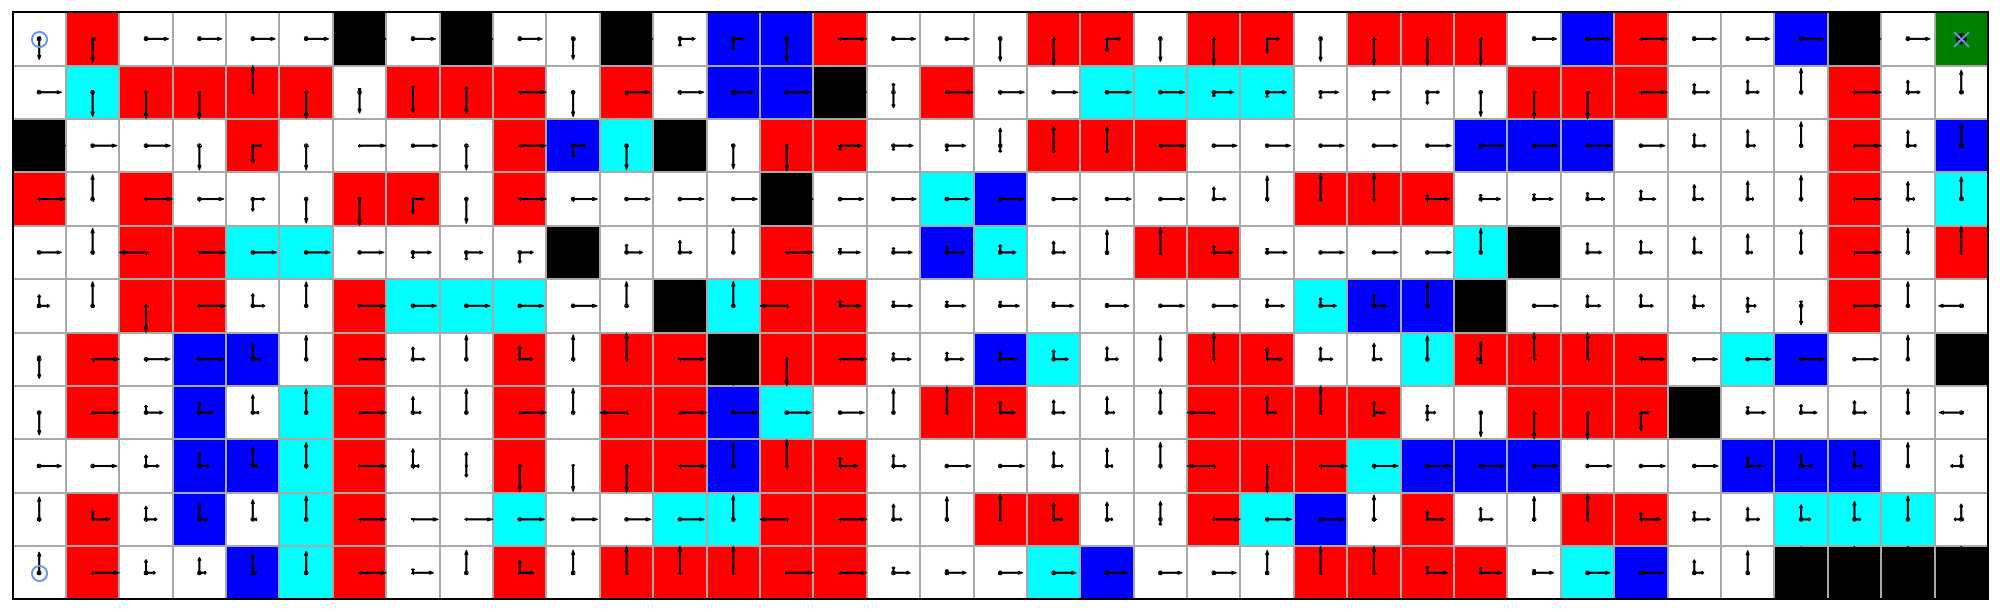

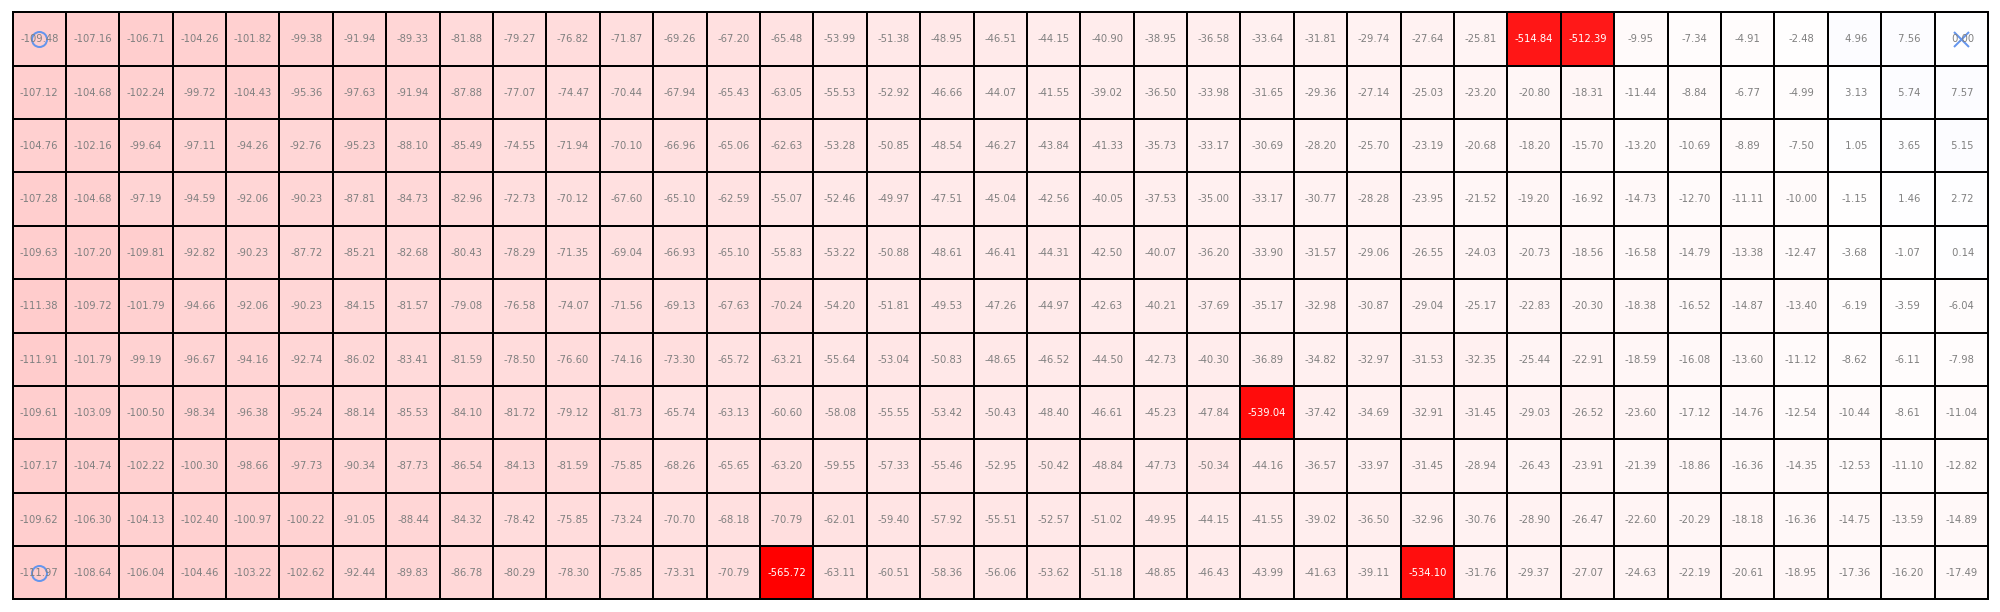

In [ ]:
# solve with matrices returned by gridworld object
my_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=the_policy.policy.detach().numpy()
)

my_state_values = dict(zip(mdp.state_list, the_policy.state_values.detach()))
mdp.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp.plot().plot_state_map(my_state_values)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [ ]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp).initial_value}")


Learned policy's initial value: -69.11514807742086
Expert's policy initial value: -54.23001904455546


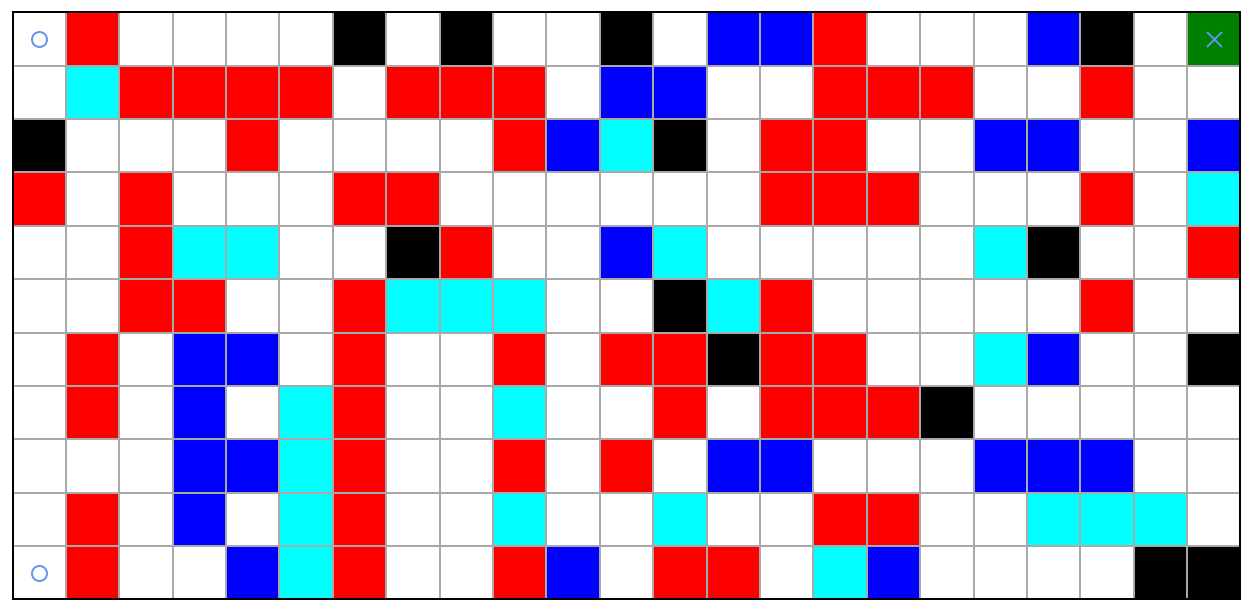

In [ ]:
# Create a gridworld
mdp2 = GridWorld(
    tile_array=[
        "xx.bb..xc..x.x.g",
        ".abb....xx.c.b.c",
        "c.b......xbac.bx",
        "x.ax..xx...xxx..",
        "s.xx.a....c.....",
        "..xx..xaba..cxxx",
        ".xsbbxx..s.xxaxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=0.99,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
mdp2.plot(featurecolors=featurecolors)


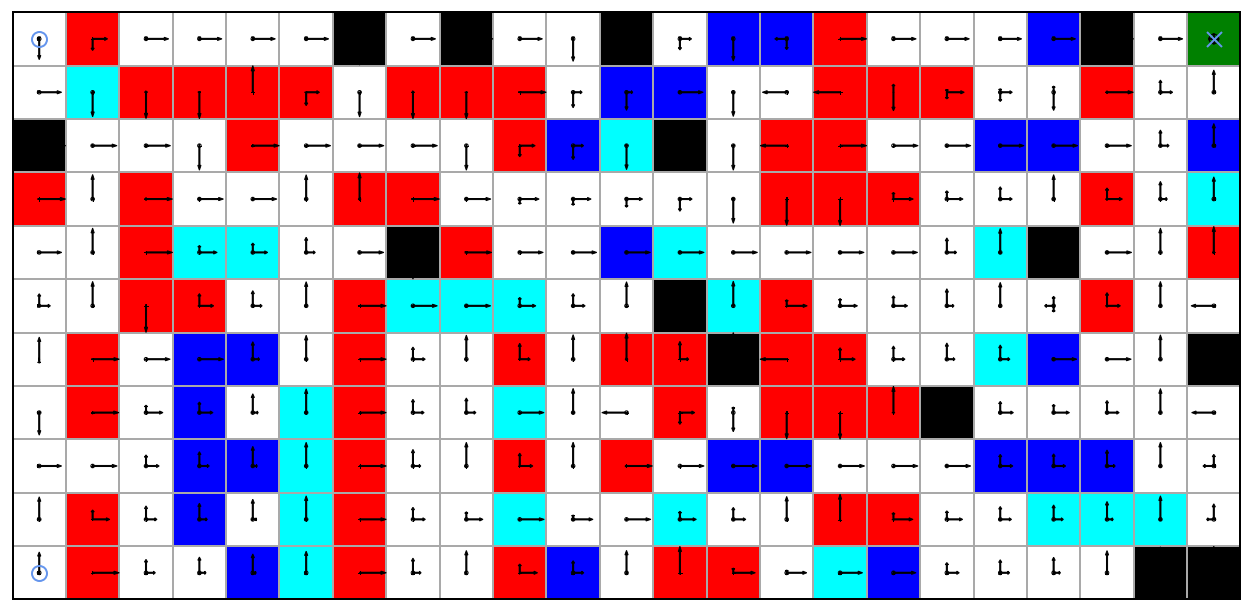

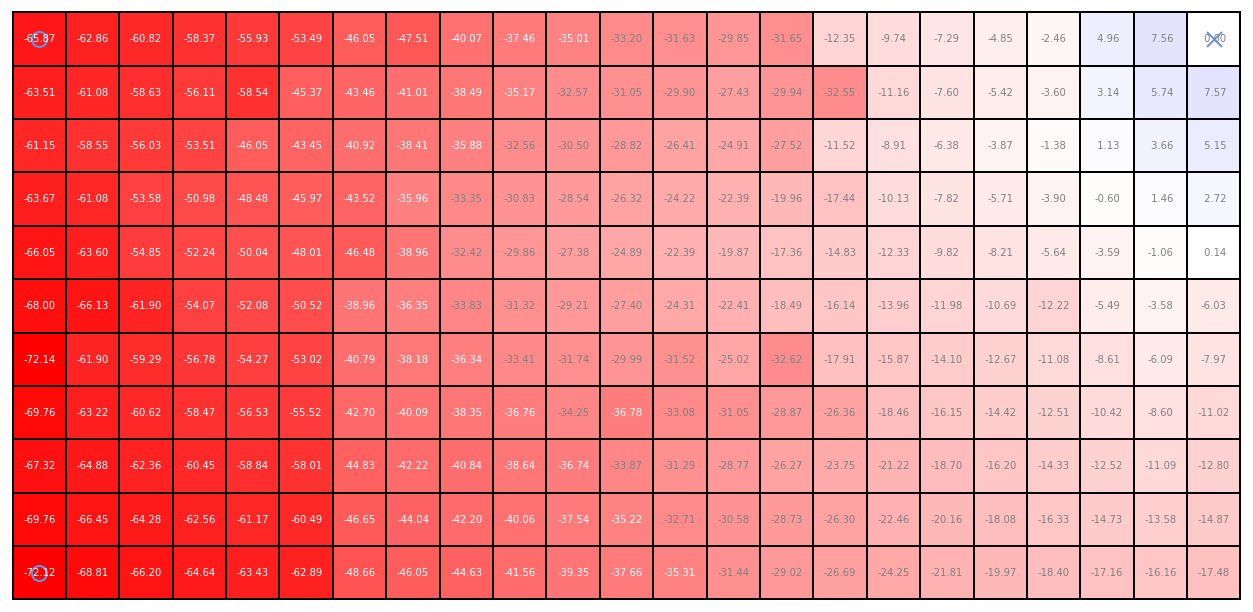

In [ ]:
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([3.9]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp2.state_list, expert_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [ ]:
def featurizer(state, action, next_state):
  feature_name = mdp2.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}


def fixed_reward(state, action, next_state):
  return mdp2.step_cost


In [ ]:
algorithm2 = MaxLikelihoodIRL(mdp2, featurizer, fixed_reward, batch_size=128, epochs=10, lr=0.1, weight_decay=0.0001, momentum=0.9)

# compute policy from learned weights
feature_reward_matrix2 = torch.einsum(
    "sanf,f->san",
    algorithm2.get_feature_matrix(),
    learned_weights
)

reward_matrix2 = feature_reward_matrix2 + algorithm2.get_fixed_reward_matrix()
terminal_index = mdp2.state_index.get(
    frozendict({'x': -1, 'y': -1}))
reward_matrix2[:, :, terminal_index] = 0

my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=reward_matrix2,
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([3.9]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


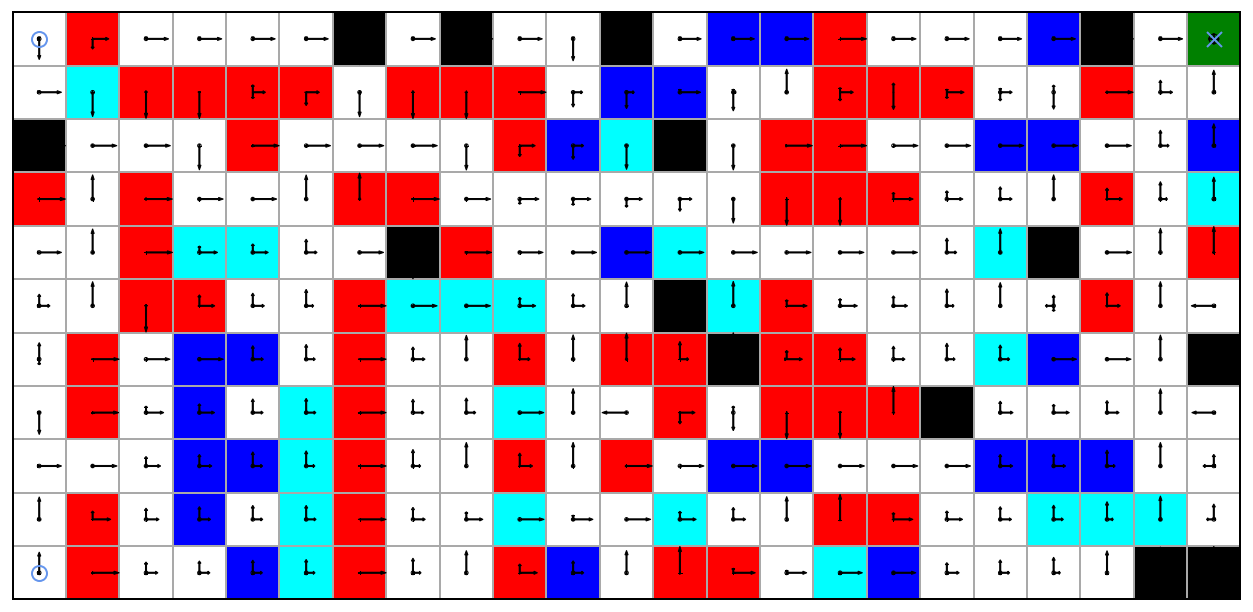

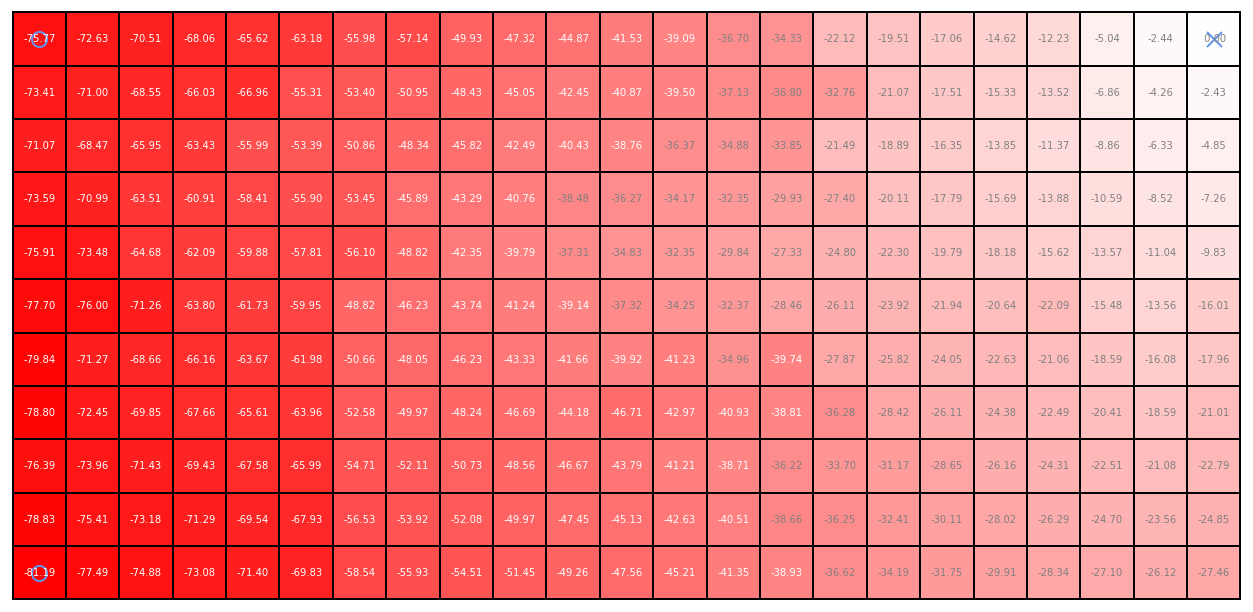

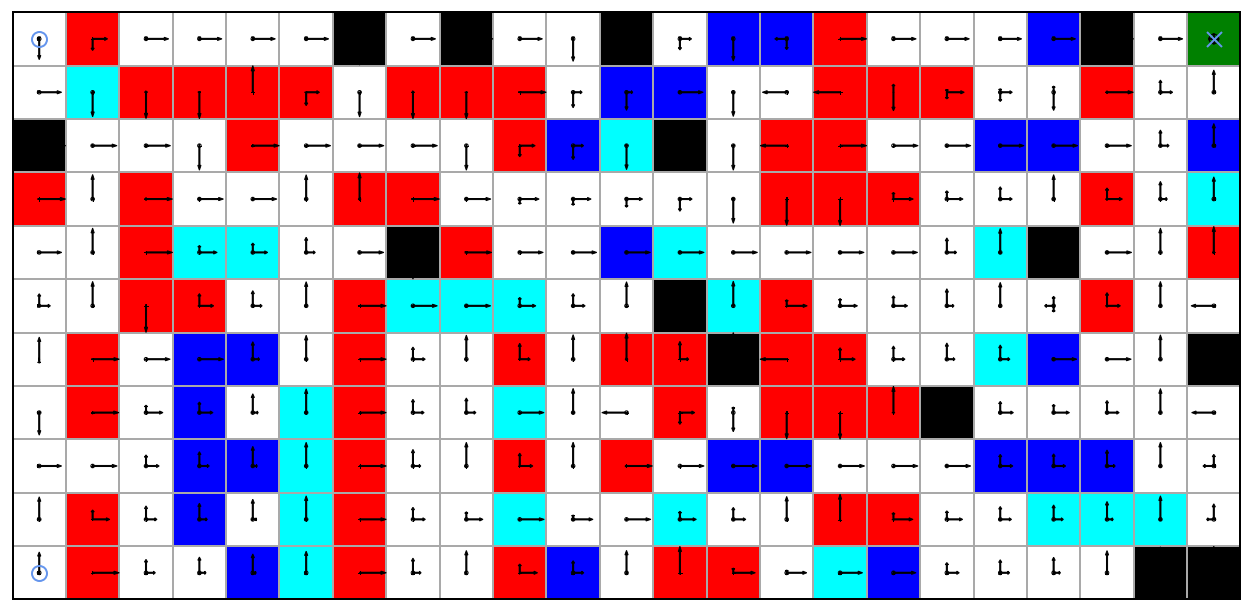

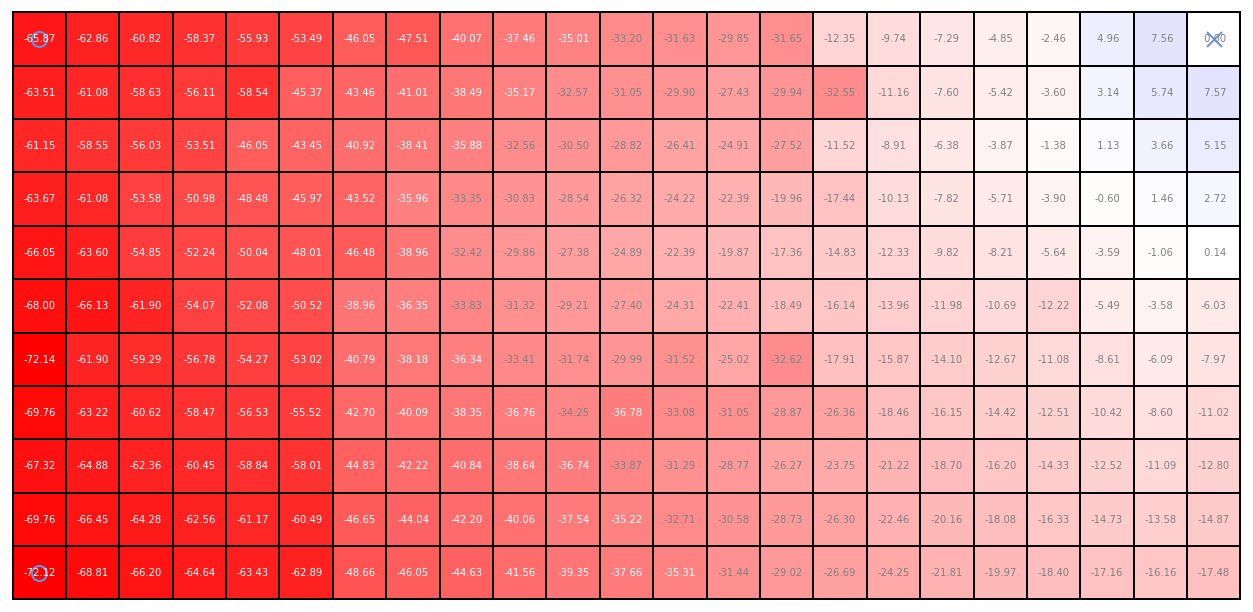

In [ ]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)

my_state_values = dict(zip(mdp2.state_list, my_erpi.state_values.detach()))
mdp2.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp2.plot().plot_state_map(my_state_values)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [ ]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp2).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp2).initial_value}")


Learned policy's initial value: -156.79460023888583
Expert's policy initial value: -28.85131295508687
